# Analisi strutturale dei datasets

In [30]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import re
from itertools import combinations
import shutil
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from itertools import combinations
import string
import collections

In [31]:
lilla = "#c8a2c8"
color_of_bar1 = "#c8a2c8"
color_of_bar2 = "#6495ED"
color_of_edge = "#000000"

In [32]:
matrix = np.array([[149030, 34],[7442, 12]])
norm = matplotlib.colors.Normalize(matrix.min(), matrix.max())
boundaries = [value for value in matrix.flatten().tolist()]
list.sort(boundaries)
colors = [[norm(boundaries[0]), "#dcc4dc"], 
          [norm(boundaries[1]), "#c8a2c8"], 
          [norm(boundaries[2]), "#93779c"], 
          [norm(boundaries[3]), "#6c4675"]]
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

In [33]:
dataset_path = "..\\..\\Dataset\\DatasetJSON\\datasets.json"

### Import dataset JSON ed estrazione numero righe, colonne e celle per ogni dataset

In [34]:
with open(dataset_path, 'r', encoding='utf-8') as f:
    json_object = json.loads(f.read())
    f.close()

In [35]:
# dato un df restituisce numero di righe, colonne e celle
def extract_data_from_df(df):
    return {
        "rows": df.shape[0],
        "columns": df.shape[1],
        "cells": df.shape[0] * df.shape[1]
    }

In [36]:
info_datasets = []
for i in range(0, len(json_object)):
    df = pd.read_json(json_object[i]["dataset"], orient="index", encoding="utf-8")
    info = extract_data_from_df(df)
    info_datasets.append([
        json_object[i]["group_name"],
        json_object[i]["dataset_name"],
        info["rows"],
        info["columns"],
        info["cells"]
    ])

In [37]:
# costruisce un df a partire da un array di array e un numero c che rappresenta la colonna su cui ordinare
# reverse serve a ordinare in senso crescente o descrescente
def get_info_order_by(list_of_info, c, reverse=False):
    sorted_list = sorted(list_of_info, key = lambda x: x[c], reverse=reverse)
    df = pd.DataFrame(sorted_list, columns=["group_name", "dataset_name", "rows", "columns", "cells"])
    return df

In [38]:
df_info = get_info_order_by(info_datasets, 1, True)
display(df_info)

group_name        dataset_name   rows  columns   cells
0   02-GioPonSpiz           wikipedia   2664        5   13320
1    05-MalPatSaj           wikipedia   3111        7   21777
2    06-MarScoToc           wikipedia    619        5    3095
3       10-DeBiGa           wikipedia   1002       13   13026
4     00-avengers          valuetoday  10682       18  192276
5   02-GioPonSpiz          valuetoday  10680        6   64080
6         03-gren          valuetoday  10682       10  106820
7         04-iGMM          valuetoday  10000       12  120000
8    07-silvestri          valuetoday   1000        9    9000
9    08-slytherin          valuetoday  10000        8   80000
10         01-DDD           teamblind    946        7    6622
11      09-wissel         infoclipper   4656       11   51216
12    00-avengers         hithorizons    667        9    6003
13      09-wissel               govuk   1321       10   13210
14      10-DeBiGa               govuk   7000        7   49000
15      10-DeBiGa          globaldata   5336        9   48024
16         01-DDD                  ft   1000       11   11000
17        03-gren                  ft   1000        8    8000
18   07-silvestri                  ft   1000        8    8000
19   08-slytherin                  ft   5000        7   35000
20   05-MalPatSaj              forbes   2000        7   14000
21   07-silvestri              forbes   1000        4    4000
22   08-slytherin              forbes   2000        8   16000
23    00-avengers             disfold   1000       11   11000
24  02-GioPonSpiz             disfold   1000        6    6000
25        03-gren             disfold   1000        6    6000
26        04-iGMM             disfold   1000       14   14000
27   05-MalPatSaj             disfold   1000        7    7000
28   06-MarScoToc             disfold    960        5    4800
29   07-silvestri             disfold   1000        5    5000
30   08-slytherin             disfold  16097        6   96582
31      10-DeBiGa             disfold   1000       10   10000
32    00-avengers  companiesmarketcap   5897        9   53073
33         01-DDD  companiesmarketcap   7217        9   64953
34  02-GioPonSpiz  companiesmarketcap   7200        5   36000
35        03-gren  companiesmarketcap   7163        4   28652
36        04-iGMM  companiesmarketcap   7093        9   63837
37   05-MalPatSaj  companiesmarketcap   7000        6   42000
38   06-MarScoToc  companiesmarketcap   6290        5   31450
39      09-wissel  companiesmarketcap   6560       11   72160
40         01-DDD          cbinsights   1185       11   13035
41        04-iGMM          cbinsights   1202        7    8414
42      09-wissel         ariregister   1469       10   14690
43   06-MarScoToc          ambitiobox   9899        5   49495

In [39]:
sum(df_info["rows"])

185598

### Plot numero di valori distinti e nulli per colonna, per ogni dataset

In [40]:
# funzione di utilita per count_type_in_list(), serve a convertire una stringa in int o float
def maybeMakeNumber(s):
    if s is np.nan:
        return None
    if s is pd.NA:
        return None
    else:
        if not isinstance(s, float):
            try:
                return int(s)
            except:
                try:
                    return float(s)
                except:
                    return s
        else:
            return s

In [41]:
# conta il numero di int, float e str in una lista di stringhe
def count_type_in_list(l):
    info = {}
    converted = list(map(maybeMakeNumber, l))
    converted = [0 if isinstance(x, int) else x for x in converted]
    converted = [1 if isinstance(x, float) else x for x in converted]
    converted = [2 if isinstance(x, str) else x for x in converted]
    info["#int"] = converted.count(0)
    info["#float"] = converted.count(1)
    info["#str"] = converted.count(2)
    return info

In [42]:
# estrazione dati da un dataframe
def extract_data_from_df(df):
    info = {}
    info["#righe"] = df.shape[0]
    info["#colonne"] = df.shape[1]
    info["#celle"] = df.shape[0] * df.shape[1]
    info["#celle_nulle"] = df.isnull().sum().sum()
    info["#righe_con_celle_nulle"] = (df.isnull().sum(axis=1) != 0).sum()
    info["#colonne_con_celle_nulle"] = (df.isnull().sum(axis=0) != 0).sum()
    info["#celle_vuote"] = (df == '').sum().sum()
    info["#righe_con_celle_vuote"] = ((df == '').sum(axis=1) != 0).sum()
    info["#colonne_con_celle_vuote"] = ((df == '').sum(axis=0) != 0).sum()
    info["#celle_int"] = 0
    info["#celle_float"] = 0
    info["#celle_str"] = 0
    info["#colonne_int"] = 0
    info["#colonne_float"] = 0
    info["#colonne_str"] = 0
    for key in df:
        column = list(df[key])
        info_type = count_type_in_list(column)
        not_value_column = len(list(filter(lambda x: x is not np.nan and x is not pd.NA, column)))
        info["#celle_int"] += info_type["#int"]
        info["#celle_float"] += info_type["#float"]
        info["#celle_str"] += info_type["#str"]
        if not_value_column == info_type["#int"]:
            info["#colonne_int"] += 1
        elif not_value_column == info_type["#float"]:
            info["#colonne_float"] += 1
        elif not_value_column == info_type["#str"]:
            info["#colonne_str"] += 1
    tmp = []
    for column in list(df.columns):
        try:
            t = df[column].nunique()
            tmp.append(t)
        except:
            v = []
            for value in df[column]:
                if value is not None:
                    v.append(','.join(value))
            t = len(set(v))
            tmp.append(t)
    info["#valori_distinti_per_colonna"] = tmp
    return info

In [43]:
tables = {}
for i in range(0, len(json_object)):
    df = pd.read_json(json_object[i]["dataset"], orient="index", encoding="utf-8")
    tables["table-" + str(i)] = extract_data_from_df(df)

In [44]:
info_tables = {
    "#tabelle": 0,
    "#tabelle_con_celle_vuote": 0,
    "#tabelle_senza_celle_vuote": 0,
    "#tabelle_con_celle_nulle": 0,
    "#tabelle_senza_celle_nulle": 0
}
info_rows = {
    "#righe": 0,
    "#righe_medie_per_tabella": 0,
    "#righe_con_celle_vuote": 0,
    "#righe_con_celle_nulle": 0,
    "#righe_con_celle_non_vuote": 0,
    "#righe_con_celle_non_nulle": 0
}
info_columns = {
    "#colonne": 0,
    "#colonne_medie_per_tabella": 0,
    "#colonne_int": 0,
    "#colonne_float": 0,
    "#colonne_str": 0,
    "#colonne_misc": 0,
    "#colonne_con_celle_vuote": 0,
    "#colonne_con_celle_nulle": 0,
    "#colonne_con_celle_non_vuote": 0,
    "#colonne_con_celle_non_nulle": 0
}
info_cells = {
    "#celle": 0,
    "#celle_int": 0,
    "#celle_float": 0,
    "#celle_str": 0,
    "#media_celle_vuote_per_tabella": 0,
    "#media_celle_nulle_per_tabella": 0,
    "#celle_vuote": 0,
    "#celle_non_vuote": 0,
    "#celle_nulle": 0,
    "#celle_non_nulle": 0
}

n_rows_dict = {}
n_columns_dict = {}
n_distinct_dict = {}
rate_distinct_dict = {}

In [45]:
info_tables["#tabelle"] = len(tables)

for key, info in tables.items():

    info_rows["#righe"] += info["#righe"]
    info_rows["#righe_con_celle_vuote"] += info["#righe_con_celle_vuote"]
    info_rows["#righe_con_celle_nulle"] += info["#righe_con_celle_nulle"]

    info_columns["#colonne"] += info["#colonne"]
    info_columns["#colonne_int"] += info["#colonne_int"]
    info_columns["#colonne_float"] += info["#colonne_float"]
    info_columns["#colonne_str"] += info["#colonne_str"]
    info_columns["#colonne_con_celle_vuote"] += info["#colonne_con_celle_vuote"]
    info_columns["#colonne_con_celle_nulle"] += info["#colonne_con_celle_nulle"]

    info_cells["#celle"] += info["#celle"]
    info_cells["#celle_int"] += info["#celle_int"]
    info_cells["#celle_float"] += info["#celle_float"]
    info_cells["#celle_str"] += info["#celle_str"]
    info_cells["#celle_vuote"] += info["#celle_vuote"]
    info_cells["#celle_non_vuote"] += info["#celle"] - info["#celle_vuote"]
    info_cells["#celle_nulle"] += info["#celle_nulle"]
    info_cells["#celle_non_nulle"] += info["#celle"] - info["#celle_nulle"]

    if info["#celle_vuote"] > 0:
        info_tables["#tabelle_con_celle_vuote"] += 1
    if info["#celle_nulle"] > 0:
        info_tables["#tabelle_con_celle_nulle"] += 1

    if info["#righe"] not in n_rows_dict.keys():
        n_rows_dict[info["#righe"]] = 0
    if info["#colonne"] not in n_columns_dict.keys():
        n_columns_dict[info["#colonne"]] = 0
    n_rows_dict[info["#righe"]] += 1
    n_columns_dict[info["#colonne"]] += 1

    for distinct_values in info["#valori_distinti_per_colonna"]:
        if distinct_values not in n_distinct_dict.keys():
            n_distinct_dict[distinct_values] = 0
        n_distinct_dict[distinct_values] += 1
        rate = int(round((distinct_values / info["#righe"]) * 100, 0))
        if rate not in rate_distinct_dict.keys():
            rate_distinct_dict[rate] = 0
        rate_distinct_dict[rate] += 1

info_tables["#tabelle_senza_celle_vuote"] = info_tables["#tabelle"] - info_tables["#tabelle_con_celle_vuote"]
info_tables["#tabelle_senza_celle_nulle"] = info_tables["#tabelle"] - info_tables["#tabelle_con_celle_nulle"]

info_rows["#righe_con_celle_non_vuote"] = info_rows["#righe"] - info_rows["#righe_con_celle_vuote"]
info_rows["#righe_con_celle_non_nulle"] = info_rows["#righe"] - info_rows["#righe_con_celle_nulle"]
info_rows["#righe_medie_per_tabella"] = info_rows["#righe"] / info_tables["#tabelle"]

info_columns["#colonne_misc"] = info_columns["#colonne"] - (
        info_columns["#colonne_int"] + info_columns["#colonne_float"] + info_columns["#colonne_str"])
info_columns["#colonne_con_celle_non_vuote"] = info_columns["#colonne"] - info_columns["#colonne_con_celle_vuote"]
info_columns["#colonne_con_celle_non_nulle"] = info_columns["#colonne"] - info_columns["#colonne_con_celle_nulle"]
info_columns["#colonne_medie_per_tabella"] = info_columns["#colonne"] / info_tables["#tabelle"]

info_cells["#media_celle_vuote_per_tabella"] = info_cells["#celle_vuote"] / info_tables["#tabelle"]
info_cells["#media_celle_nulle_per_tabella"] = info_cells["#celle_nulle"] / info_tables["#tabelle"]

r = collections.OrderedDict(sorted(n_rows_dict.items()))
n_rows_dict = dict(r)
c = collections.OrderedDict(sorted(n_columns_dict.items()))
n_columns_dict = dict(c)
d = collections.OrderedDict(sorted(n_distinct_dict.items()))
n_distinct_dict = dict(d)
r = collections.OrderedDict(sorted(rate_distinct_dict.items()))
rate_distinct_dict = dict(r)

In [46]:
color_of_bar = "#C8A2C8"
color_of_edge = "#000000"

counter = 0

def make_path(file_name):
    global counter
    counter += 1
    return ".\\plot\\" + str(counter) + "-" + file_name

In [47]:
def plot_bar(keys, values, title, dim):
    file_name = "".join(title.lower()).replace(" ", "_")
    labels = ["{:,}".format(elem) for elem in values]
    labels = list(map(lambda x: x.replace(',', ' '), labels))

    plt.figure(figsize=dim)
    plt.grid(color=color_of_edge, linestyle='-', linewidth=0.2, axis="y")
    plt.title(title)
    plt.yticks(values, labels)
    plt.bar(keys, values, width=0.5, color=color_of_bar, edgecolor=color_of_edge, linewidth=1, align='center')
    plt.savefig(make_path(file_name), bbox_inches='tight', transparent=True)
    plt.show()

In [48]:
def plot_distribution(dict_of_distribution, title, xlabel, ylabel, dist, dim, type_of_plot):
    plt.figure(figsize=dim)
    plt.grid(color=color_of_edge, linestyle='-', linewidth=0.2, axis="y")

    file_name = "".join(title.lower()).replace(" ", "_")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    list1 = list(range(0, len(dict_of_distribution)))
    list2 = list(map(str, dict_of_distribution.keys()))
    list1 = list1[slice(0, len(list1), dist)]
    list2 = list2[slice(0, len(list2), dist)]
    plt.xticks(list1, list2, rotation=90)

    x = list(map(str, dict_of_distribution.keys()))
    y = list(dict_of_distribution.values())

    if type_of_plot:
        plt.bar(x, y, width=1.0, color=color_of_bar, align='center')
        plt.plot(x, y, linewidth=1, color=color_of_edge)
    else:
        plt.bar(x, y, width=1.0, color=color_of_bar, edgecolor=color_of_edge, linewidth=1, align='center')

    plt.savefig(make_path(file_name), bbox_inches='tight', transparent=True)
    plt.show()

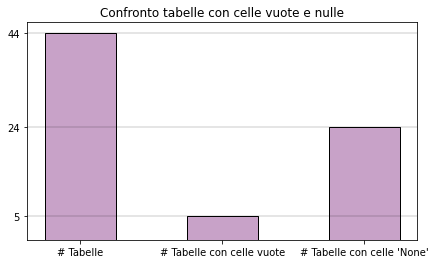

In [49]:
keys = ["# Tabelle", "# Tabelle con celle vuote", "# Tabelle con celle 'None'"]
values = [info_tables["#tabelle"], info_tables["#tabelle_con_celle_vuote"], info_tables["#tabelle_con_celle_nulle"]]
title = "Confronto tabelle con celle vuote e nulle"
dim = (7, 4)
plot_bar(keys, values, title, dim)

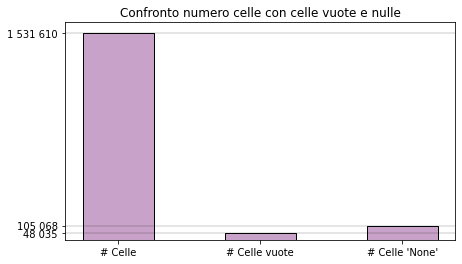

In [50]:
keys = ["# Celle", "# Celle vuote", "# Celle 'None'"]
values = [info_cells["#celle"], info_cells["#celle_vuote"], info_cells["#celle_nulle"]]
title = "Confronto numero celle con celle vuote e nulle"
dim = (7, 4)
plot_bar(keys, values, title, dim)

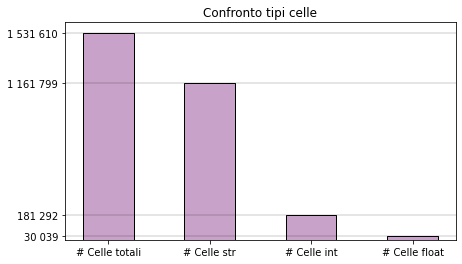

In [51]:
keys = ["# Celle totali", "# Celle str", "# Celle int", "# Celle float"]
values = [info_cells["#celle"], info_cells["#celle_str"], info_cells["#celle_int"], info_cells["#celle_float"]]
title = "Confronto tipi celle"
dim = (7, 4)
plot_bar(keys, values, title, dim)

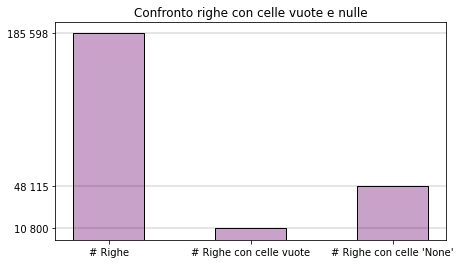

In [52]:
keys = ["# Righe", "# Righe con celle vuote", "# Righe con celle 'None'"]
values = [info_rows["#righe"], info_rows["#righe_con_celle_vuote"], info_rows["#righe_con_celle_nulle"]]
title = "Confronto righe con celle vuote e nulle"
dim = (7, 4)
plot_bar(keys, values, title, dim)

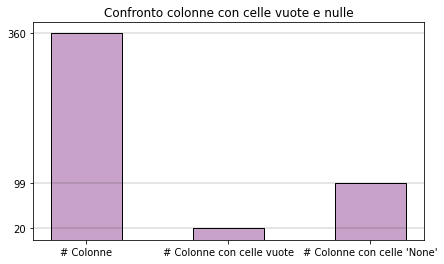

In [53]:
keys = ["# Colonne", "# Colonne con celle vuote", "# Colonne con celle 'None'"]
values = [info_columns["#colonne"], info_columns["#colonne_con_celle_vuote"],
          info_columns["#colonne_con_celle_nulle"]]
title = "Confronto colonne con celle vuote e nulle"
dim = (7, 4)
plot_bar(keys, values, title, dim)

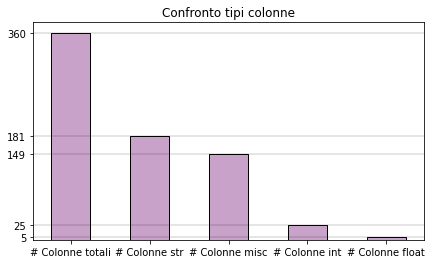

In [54]:
keys = ["# Colonne totali", "# Colonne str", "# Colonne misc", "# Colonne int", "# Colonne float"]
values = [info_columns["#colonne"], info_columns["#colonne_str"], info_columns["#colonne_misc"],
          info_columns["#colonne_int"], info_columns["#colonne_float"]]
title = "Confronto tipi colonne"
dim = (7, 4)
plot_bar(keys, values, title, dim)

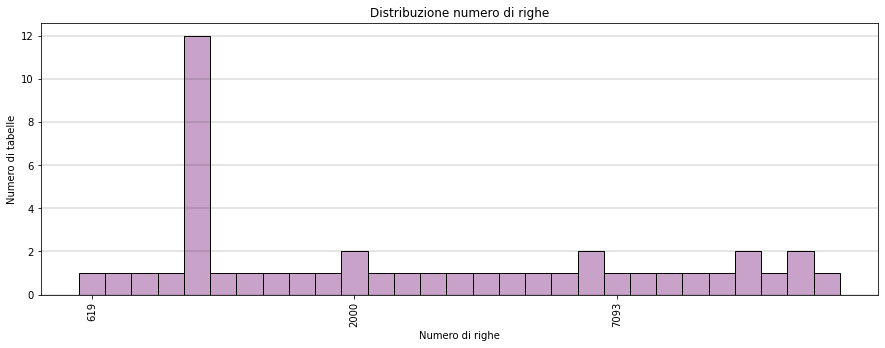

In [55]:
plot_distribution(n_rows_dict, "Distribuzione numero di righe", "Numero di righe", "Numero di tabelle", 10, (15, 5), False)

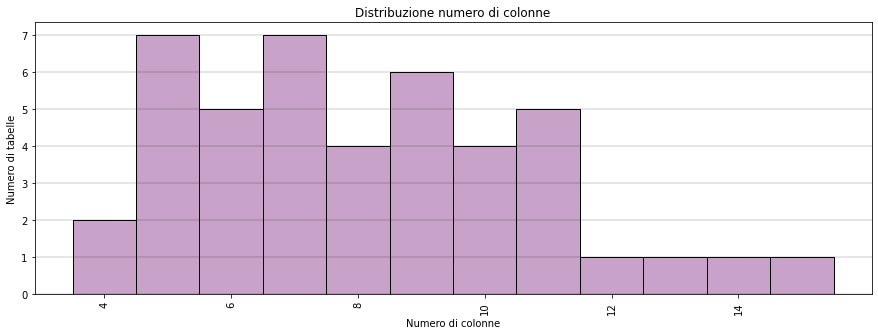

In [56]:
plot_distribution(n_columns_dict, "Distribuzione numero di colonne", "Numero di colonne", "Numero di tabelle", 2, (15, 5), False)

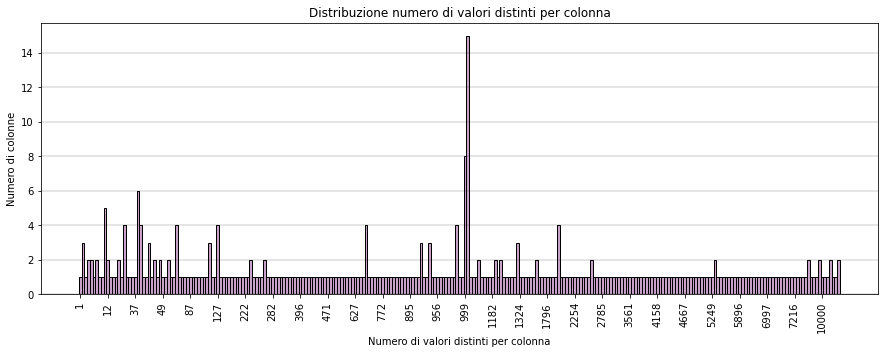

In [57]:
plot_distribution(n_distinct_dict, "Distribuzione numero di valori distinti per colonna", "Numero di valori distinti per colonna", "Numero di colonne", 10, (15, 5), False)

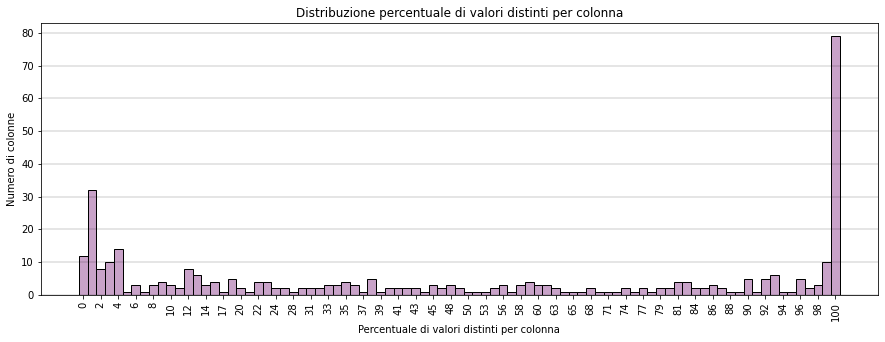

In [58]:
plot_distribution(rate_distinct_dict, "Distribuzione percentuale di valori distinti per colonna", "Percentuale di valori distinti per colonna", "Numero di colonne", 2, (15, 5), False)

### Word cloud

In [59]:
for i in range(0, len(json_object)):
    
    df = pd.read_json(json_object[i]["dataset"], orient="index", encoding="utf-8")
    for column in list(df.columns):
        if column == "name":
            df[column] = df[column].fillna(value="")

            word_string = ""

            for val in df[column]:
                val = str(val)
                tokens = val.split()
                for token in tokens:
                    t = re.sub('[^A-Za-z]+', ' ', token)
                    t = t.lower()
                    other_tokens = t.split()
                    tmp = "".join(other_tokens)
                    if len(tmp) > 3:
                        word_string += tmp+" "
                
            with open('words.txt', 'a', encoding='utf-8') as f:
                f.write(word_string) 

In [60]:
dict_frequent_term = {}
with open('words.txt', 'r', encoding='utf-8') as f:
    word_string = f.read() 
    for token in word_string.split():
        if token not in dict_frequent_term.keys():
            dict_frequent_term[token] = 0
        dict_frequent_term[token] += 1
dict_frequent_term = dict(sorted(dict_frequent_term.items(), key=lambda x: x[1], reverse=True))

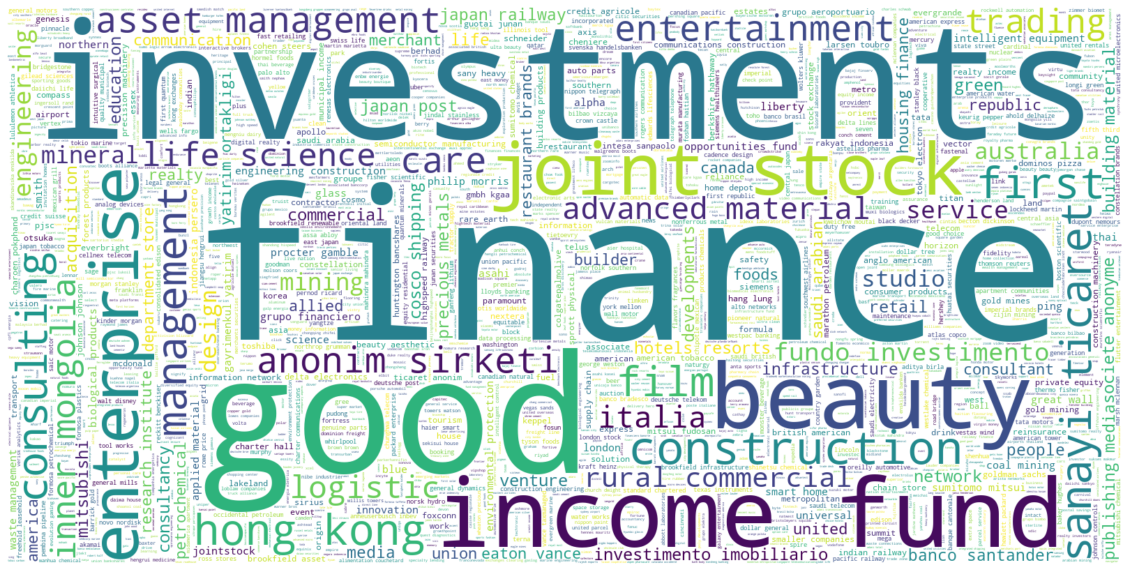

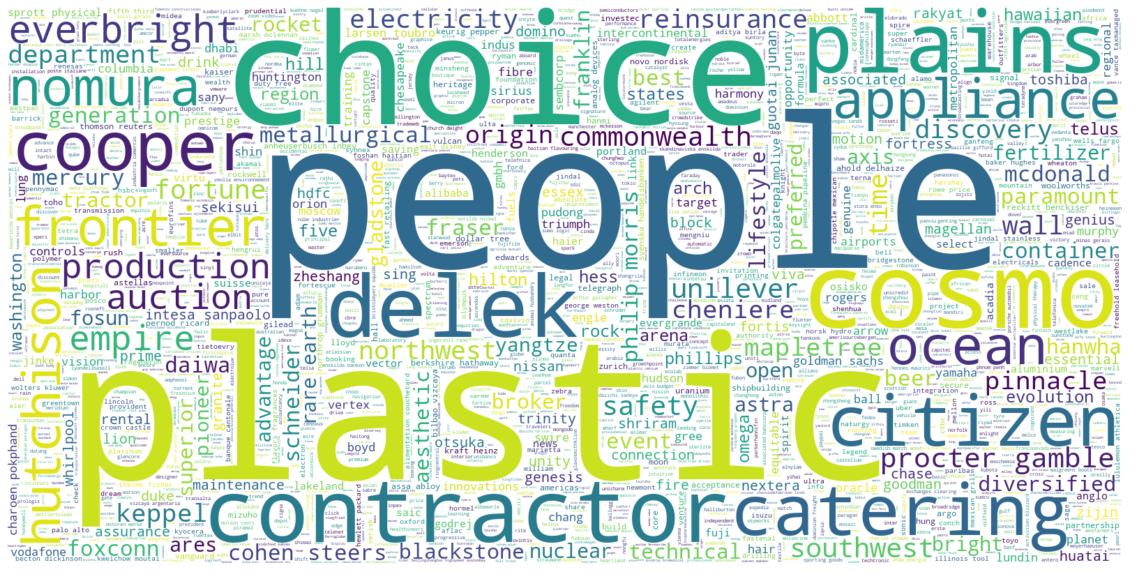

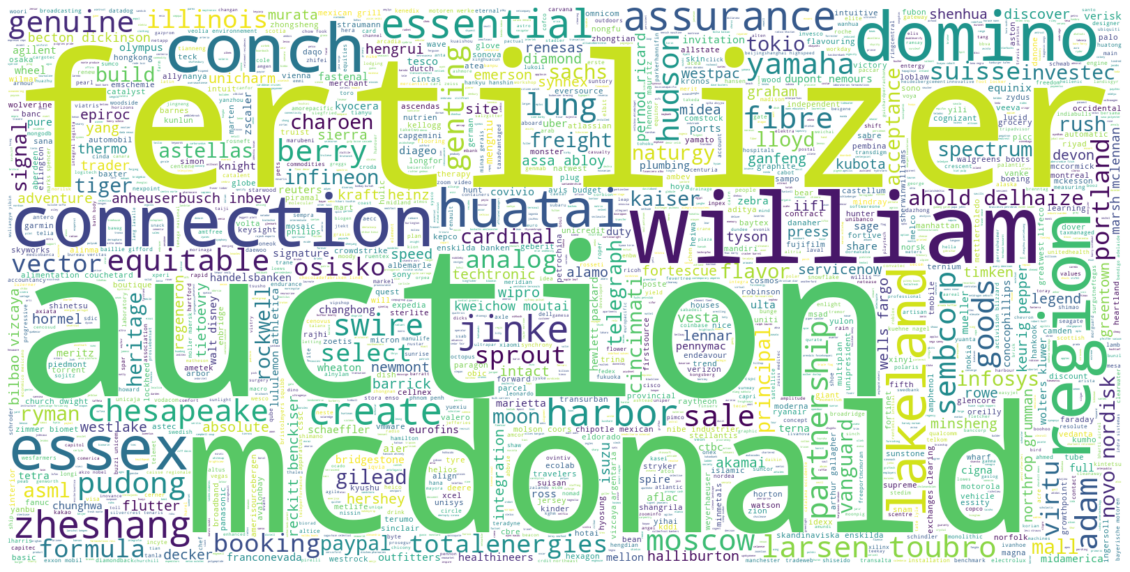

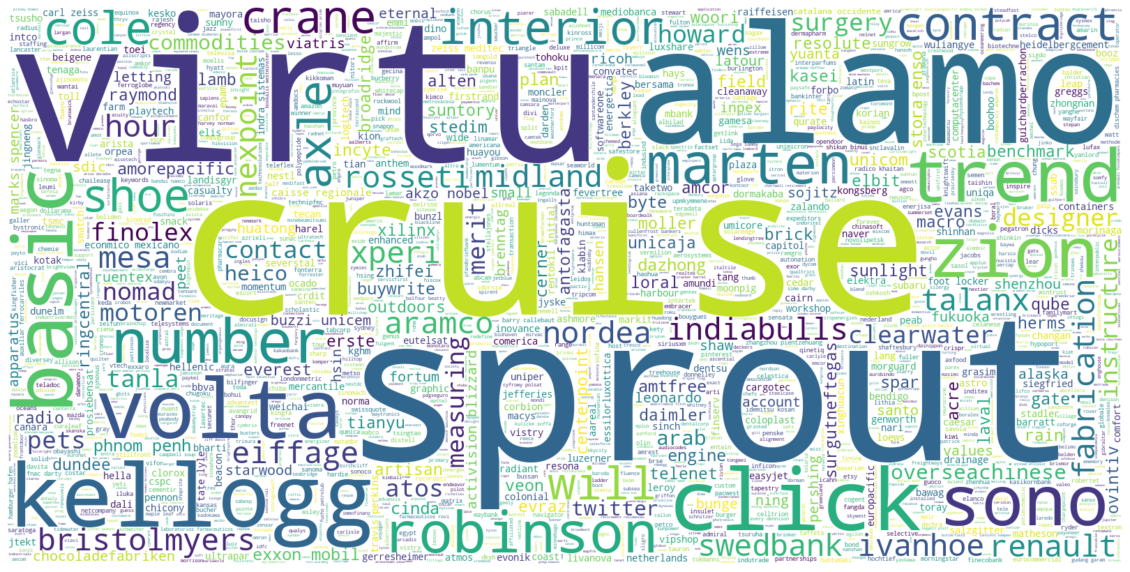

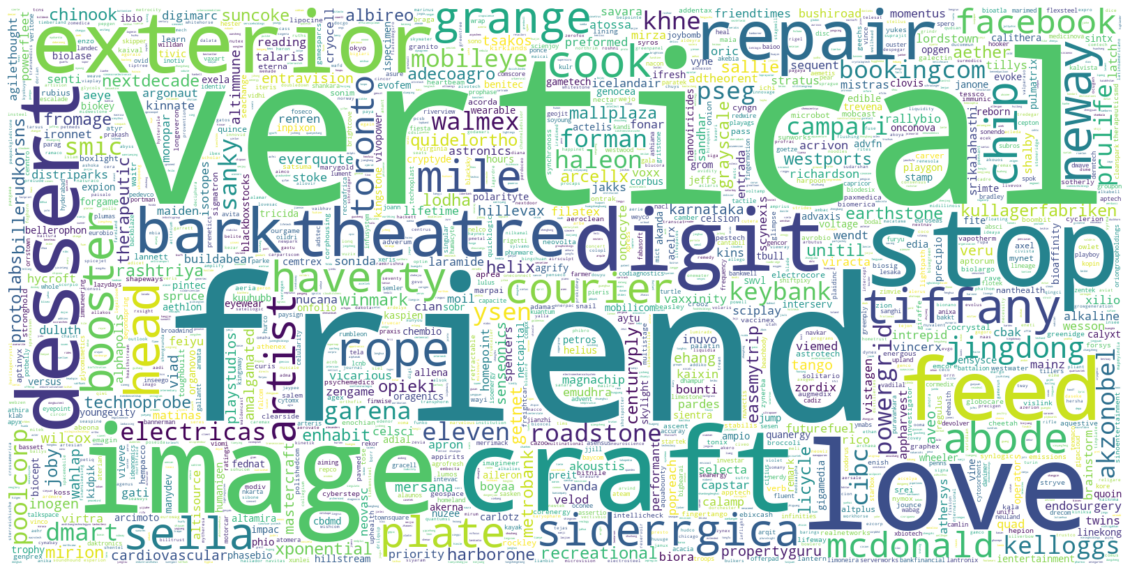

In [61]:
for x in [1000, 100, 50, 30, 10]:
    stop = {k: v for k, v in dict_frequent_term.items() if v > x}
    with open('words.txt', 'r', encoding='utf-8') as f:
        word_string = f.read() 

        plt.figure(figsize=(20,20))

        stop_words = list(STOPWORDS) + list(stop.keys())
        
        wc = WordCloud(background_color="white", stopwords = stop_words, max_words=2000, max_font_size= 300,  width=1600, height=800)
        wc.generate(word_string)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis('off')
        plt.savefig(str(x)+"-wordcloud", bbox_inches='tight', transparent=True)